# NCAA Starter
- Seeds 
- Season Compact Results
- Tourney Compact Results

In [64]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

## Data preparation
### Seeds

In [65]:
seeds = pd.read_csv('Dades/WNCAATourneySeeds.csv') #CANVIAR RUTA
seeds.head()

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272


### Season results
Pujo l'arxiu WRegularSeasonCompactResults.csv 

Trec les columnes 'NumOT' i 'WLoc', número de pròrrogues i si el partit es jugava a casa o a fora. 

Afegeixo la columa 'ScoreGap', la diferència de punts a final del partit. 

In [66]:
season_results = pd.read_csv('Dades/WRegularSeasonCompactResults.csv')
season_results.drop(['NumOT','WLoc'], axis=1, inplace=True) #treure les columnes de número de pròrrogues i si es jugava  a casa/fora
season_results['ScoreGap']=season_results['WScore']-season_results['LScore'] #afegir columna de diferencia de punts


In [67]:
season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreGap
0,1998,18,3104,91,3202,41,50
1,1998,18,3163,87,3221,76,11
2,1998,18,3222,66,3261,59,7
3,1998,18,3307,69,3365,62,7
4,1998,18,3349,115,3411,35,80


### Features

per cada equip a cada temporada, es calculen: 

- Numero de victòries
- Numero de derrotes
- Mitjana de diferència de punts en les victòries (gap of wins)
- Mitjana de diferència de punts en les derrotes (gap of losses)

i s'utilitzen per calcular el nous atributs:
- Win Ratio
- Average score gap

In [68]:
num_win = season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [69]:
num_loss = season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [70]:
gap_win = season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [71]:
gap_loss = season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

Es crea una llista (features_season) amb les temporades i els equips que han jugat algun partit en elles


In [72]:
features_season_w = season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
 # temporada, equip q ha guanyat algun partit
features_season_l = season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})
 # temporada, equip q ha perdut algun partit 

In [73]:
features_season = pd.concat([features_season_w, features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

/var/folders/k8/r4h7_jnd61ldq5l8mlwk8dhc0000gn/T/ipykernel_2980/2180906825.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  features_season = pd.concat([features_season_w, features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)


A cada equip li afegim els features calculats abans: num_win, num_loss, gap_win i gap_loss

In [74]:
features_season = features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
features_season = features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
features_season = features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
features_season = features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')
features_season.head()

,Season,TeamID,NumWins,NumLosses,GapWins,GapLosses
0,1998,3102,4.0,20.0,15.500000,27.850000
1,1998,3103,11.0,18.0,15.000000,18.611111
2,1998,3104,21.0,9.0,21.619048,5.666667
3,1998,3106,6.0,15.0,8.333333,14.466667
4,1998,3108,12.0,11.0,17.750000,16.636364


Comprovem si hi ha valors nuls al DataFrame i els substituïm per 0.

In [75]:
features_season.isnull().sum()

Season        0
TeamID        0
NumWins      25
NumLosses    14
GapWins      25
GapLosses    14
dtype: int64

In [76]:
features_season.fillna(0, inplace=True)

Seguidament es creen dos atributs nous: 

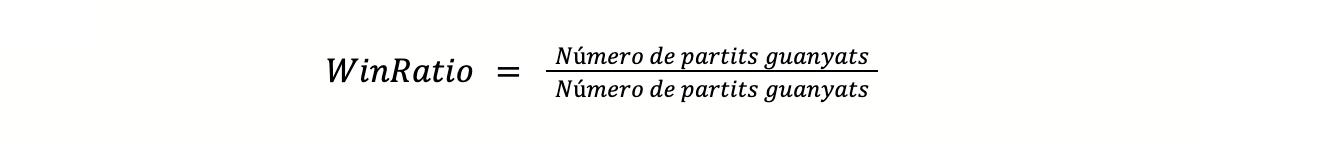

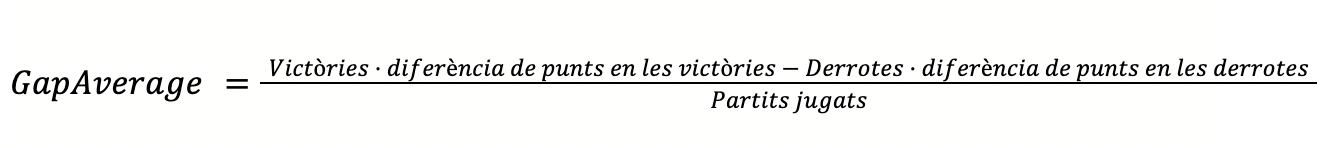

In [77]:
features_season['WinRatio'] = features_season['NumWins']/(features_season['NumWins']+features_season['NumLosses']) #victories/total partits jugats
features_season['GapAvg']=(features_season['NumWins']*features_season['GapWins']-features_season['NumLosses']*features_season['GapLosses'])/(features_season['NumWins']+features_season['NumLosses'])
 #mitja ponderada de la diferencia de punts en un partit
features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)
features_season.head()

,Season,TeamID,WinRatio,GapAvg
0,1998,3102,0.166667,-20.625000
1,1998,3103,0.379310,-5.862069
2,1998,3104,0.700000,13.433333
3,1998,3106,0.285714,-7.952381
4,1998,3108,0.521739,1.304348


### Tourney results

Pujo l'arxiu WNCAATourneyCompactResults al qual li trec els atributs de número de pròrrogues i si el partit es jugava a “casa” o fora.

In [78]:
tourney_results = pd.read_csv('Dades/WNCAATourneyCompactResults.csv')
tourney_results.drop(['NumOT','WLoc'], axis=1, inplace=True)

Substitueixo el DayNum per la ronda del torneig de la que es tracta


In [79]:
def get_round(day):
    round_dic = {137: 0, 138: 0, 139: 1, 140: 1, 141: 2, 144: 3, 145: 3, 146: 4, 147: 4, 148: 4, 151:5, 153: 5, 155: 6} # comprovar q estigui bé -> ok
    try:
        return round_dic[day]
    except:
        print(f'Unknow day : {day}')
        return 0

In [80]:
tourney_results['Round'] = tourney_results['DayNum'].apply(get_round)
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round
0,1998,137,3104,94,3422,46,0
1,1998,137,3112,75,3365,63,0
2,1998,137,3163,93,3193,52,0
3,1998,137,3198,59,3266,45,0
4,1998,137,3203,74,3208,72,0


## Feature Engineering


In [81]:
df=tourney_results.copy()
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round
0,1998,137,3104,94,3422,46,0
1,1998,137,3112,75,3365,63,0
2,1998,137,3163,93,3193,52,0
3,1998,137,3198,59,3266,45,0
4,1998,137,3203,74,3208,72,0


Cada fila correspon a un partit entre WTeamID i LTeamID


### Seeds

In [82]:
#s'està afegint la seed en la que es trobava cada WTeam a la temporada indicada (perque tal cual concatenat no es corresponen)
df=pd.merge(df, seeds, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})
#es borren columnes repetides

In [83]:
#el mateix pero afegint la seed del LTeam
df=pd.merge(df, seeds, how='left', left_on=['Season','LTeamID'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed':'SeedL'})
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round,SeedW,SeedL
0,1998,137,3104,94,3422,46,0,X02,X15
1,1998,137,3112,75,3365,63,0,W03,W14
2,1998,137,3163,93,3193,52,0,W02,W15
3,1998,137,3198,59,3266,45,0,Y07,Y10
4,1998,137,3203,74,3208,72,0,W10,W07


In [84]:
#facilitar numenclatura de les seeds, trec la lletra
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [85]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [86]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round,SeedW,SeedL
0,1998,137,3104,94,3422,46,0,2,15
1,1998,137,3112,75,3365,63,0,3,14
2,1998,137,3163,93,3193,52,0,2,15
3,1998,137,3198,59,3266,45,0,7,10
4,1998,137,3203,74,3208,72,0,10,7


### Season stats (features)

Afegim el WinRatioW, WinRatioL, GapAvgW, GapAvgL corresponent a cada fila de df

In [87]:
df=pd.merge(df, features_season, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).rename(columns={'WinRatio': 'WinRatioW', 'GapAvg': 'GapAvgW'}).drop(columns='TeamID', axis=1)

In [88]:
df=pd.merge(df, features_season, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']).rename(columns={'WinRatio': 'WinRatioL', 'GapAvg': 'GapAvgL'}).drop(columns='TeamID', axis=1)

In [89]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round,SeedW,SeedL,WinRatioW,GapAvgW,WinRatioL,GapAvgL
0,1998,137,3104,94,3422,46,0,2,15,0.700000,13.433333,0.703704,6.111111
1,1998,137,3112,75,3365,63,0,3,14,0.777778,12.407407,0.785714,17.821429
2,1998,137,3163,93,3193,52,0,2,15,0.937500,24.875000,0.714286,5.071429
3,1998,137,3198,59,3266,45,0,7,10,0.965517,25.103448,0.769231,9.538462
4,1998,137,3203,74,3208,72,0,10,7,0.653846,9.653846,0.653846,4.730769


### Rename

Winners → A 

Losers → B

In [90]:
win_rename = {"WTeamID": "TeamIdA", "WScore" : "ScoreA", "LTeamID" : "TeamIdB", "LScore": "ScoreB", "SeedW": "SeedA", "SeedL": "SeedB", 'WinRatioW' : 'WinRatioA','WinRatioL' : 'WinRatioB', 'GapAvgW' : 'GapAvgA', 'GapAvgL' : 'GapAvgB'}
df=df.rename(columns=win_rename)

In [91]:
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,Round,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB
0,1998,137,3104,94,3422,46,0,2,15,0.700000,13.433333,0.703704,6.111111
1,1998,137,3112,75,3365,63,0,3,14,0.777778,12.407407,0.785714,17.821429
2,1998,137,3163,93,3193,52,0,2,15,0.937500,24.875000,0.714286,5.071429
3,1998,137,3198,59,3266,45,0,7,10,0.965517,25.103448,0.769231,9.538462
4,1998,137,3203,74,3208,72,0,10,7,0.653846,9.653846,0.653846,4.730769


### Girar els partits

In [92]:
import random
def canvia(fila):
  if random.choice(['S', 'N']) == 'S':
    aux = fila['TeamIdA']
    fila['TeamIdA'] = fila['TeamIdB']
    fila['TeamIdB'] = aux
    aux1=fila['ScoreA']
    fila['ScoreA'] = fila['ScoreB']
    fila['ScoreB'] = aux1
    aux2=fila['SeedA']
    fila['SeedA'] = fila['SeedB']
    fila['SeedB'] = aux2
    aux3=fila['WinRatioA']
    fila['WinRatioA']=fila['WinRatioB']
    fila['WinRatioB']=aux3
    aux4=fila['GapAvgA']
    fila['GapAvgA']=fila['GapAvgB']
    fila['GapAvgB']=aux4
  return fila

In [93]:
df=df.apply(canvia, axis=1)
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,Round,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB
0,1998.0,137.0,3422.0,46.0,3104.0,94.0,0.0,15.0,2.0,0.703704,6.111111,0.700000,13.433333
1,1998.0,137.0,3112.0,75.0,3365.0,63.0,0.0,3.0,14.0,0.777778,12.407407,0.785714,17.821429
2,1998.0,137.0,3163.0,93.0,3193.0,52.0,0.0,2.0,15.0,0.937500,24.875000,0.714286,5.071429
3,1998.0,137.0,3198.0,59.0,3266.0,45.0,0.0,7.0,10.0,0.965517,25.103448,0.769231,9.538462
4,1998.0,137.0,3208.0,72.0,3203.0,74.0,0.0,7.0,10.0,0.653846,4.730769,0.653846,9.653846


### Differences

S'afegeixen tres columnes que siguin la diferencia entre Seeds, WinRatio i GapAvg. 

Això ajudarà a veure com de millor (o pitjor) és l'equip A que el  B. 


In [94]:
df['SeedDiff'] = df['SeedA'] - df['SeedB']
df['WinRatioDiff'] = df['WinRatioA'] - df['WinRatioB']
df['GapAvgDiff'] = df['GapAvgA'] - df['GapAvgB']
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,Round,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff
0,1998.0,137.0,3422.0,46.0,3104.0,94.0,0.0,15.0,2.0,0.703704,6.111111,0.700000,13.433333,13.0,0.003704,-7.322222
1,1998.0,137.0,3112.0,75.0,3365.0,63.0,0.0,3.0,14.0,0.777778,12.407407,0.785714,17.821429,-11.0,-0.007937,-5.414021
2,1998.0,137.0,3163.0,93.0,3193.0,52.0,0.0,2.0,15.0,0.937500,24.875000,0.714286,5.071429,-13.0,0.223214,19.803571
3,1998.0,137.0,3198.0,59.0,3266.0,45.0,0.0,7.0,10.0,0.965517,25.103448,0.769231,9.538462,-3.0,0.196286,15.564987
4,1998.0,137.0,3208.0,72.0,3203.0,74.0,0.0,7.0,10.0,0.653846,4.730769,0.653846,9.653846,-3.0,0.000000,-4.923077


### Target

1: l'equip A ha guanyat a l'equip B

0: l'equip A ha perdut contra l'equip B


In [95]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

In [96]:
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,Round,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff,ScoreDiff,WinA
0,1998.0,137.0,3422.0,46.0,3104.0,94.0,0.0,15.0,2.0,0.703704,6.111111,0.700000,13.433333,13.0,0.003704,-7.322222,-48.0,0
1,1998.0,137.0,3112.0,75.0,3365.0,63.0,0.0,3.0,14.0,0.777778,12.407407,0.785714,17.821429,-11.0,-0.007937,-5.414021,12.0,1
2,1998.0,137.0,3163.0,93.0,3193.0,52.0,0.0,2.0,15.0,0.937500,24.875000,0.714286,5.071429,-13.0,0.223214,19.803571,41.0,1
3,1998.0,137.0,3198.0,59.0,3266.0,45.0,0.0,7.0,10.0,0.965517,25.103448,0.769231,9.538462,-3.0,0.196286,15.564987,14.0,1
4,1998.0,137.0,3208.0,72.0,3203.0,74.0,0.0,7.0,10.0,0.653846,4.730769,0.653846,9.653846,-3.0,0.000000,-4.923077,-2.0,0


In [97]:
#guardar df a un csv
df.to_csv('Dades/WNCAA df', index=False)

## Test Data

In [98]:
df_test = pd.read_csv('Dades/WSampleSubmissionStage2.csv')
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB
0,2021_3104_3112,0.5,2021,3104,3112
1,2021_3104_3116,0.5,2021,3104,3116
2,2021_3104_3124,0.5,2021,3104,3124
3,2021_3104_3125,0.5,2021,3104,3125
4,2021_3104_3133,0.5,2021,3104,3133


afegir la informació de seeds

In [99]:
df_test= pd.merge(df_test, seeds, how='left', left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})
df_test= pd.merge(df_test, seeds, how='left', left_on=['Season','TeamIdB'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed':'SeedB'})

In [100]:
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

afegir la informació de features_season

In [101]:
df_test=pd.merge(df_test, features_season, how='left', left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID']).rename(columns={'WinRatio': 'WinRatioA', 'GapAvg': 'GapAvgA'}).drop(columns='TeamID', axis=1)
df_test=pd.merge(df_test, features_season, how='left', left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID']).rename(columns={'WinRatio': 'WinRatioB', 'GapAvg': 'GapAvgB'}).drop(columns='TeamID', axis=1)

afegir differences

In [102]:
df_test['SeedDiff'] = df_test['SeedA'] - df_test['SeedB']
df_test['WinRatioDiff'] = df_test['WinRatioA'] - df_test['WinRatioB']
df_test['GapAvgDiff'] = df_test['GapAvgA'] - df_test['GapAvgB']

In [103]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff
0,2021_3104_3112,0.5,2021,3104,3112,7,3,0.64,4.76,0.761905,10.523810,4,-0.121905,-5.763810
1,2021_3104_3116,0.5,2021,3104,3116,7,4,0.64,4.76,0.703704,9.000000,3,-0.063704,-4.240000
2,2021_3104_3124,0.5,2021,3104,3124,7,2,0.64,4.76,0.925926,27.111111,5,-0.285926,-22.351111
3,2021_3104_3125,0.5,2021,3104,3125,7,12,0.64,4.76,0.800000,12.320000,-5,-0.160000,-7.560000
4,2021_3104_3133,0.5,2021,3104,3133,7,11,0.64,4.76,0.592593,4.592593,-4,0.047407,0.167407


In [104]:
#guardar df_test a un csv
df_test.to_csv('Dades/WNCAA df_test.csv', index=False)